In [1]:
#import modules

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u
from scipy.fft import fft, fftfreq

In [2]:
def accel(x,y,a):
    '''compute the x or y component of the acceleration given x and y

    Inputs:

    x: astropy quantity (cm)

        x location of the electron

    y: astropy quantity (cm)

        y location of the electron

    a: astropy quantity (cm)

        Either x or y, depending on what
        component of the acceleration is
        to be computed

    Returns:

        acc: astropy quantity (cm/s^2)

            x or y component of the acceleration

    

    '''

    #charge of an electron
    e=c.e.esu

    #mass of an electron
    me=c.m_e.cgs

    #compute the acceleration
    acc=-a*e**2/(me*((x*x+y*y)**(3/2)))

    #return the acceleration
    return acc

In [176]:
def integrate(b,v0,t_max,n_steps):
    '''Perform numerical integration using the verlet method and given initial conditions

    Inputs:
        b: float (bohr radii)

            initial y position of the electron

        v0: numpy quanitity, cm/s

            initial x velocity of the electron

        t_max: float (seconds)

            time integrator will run to, in seconds

        n_steps: integer

            number of steps for the integrator to take


    Outputs:

        t_list: np array (seconds)

            array holding all of the times in the simulation

        x_list: np array (cm)

            array holding the x positions of the electron at each time step

        y_list: np array (cm)

            array holding the y positions of the electron at each time step

        vx_list: np array (cm/s)

            array holding the x velocity of the electron at each time step

        vy_list: np array (cm/s)

            array holding the y velocity of the electron at each time step

        ax_list: np array (cm/s^2)

            array holding the x acceleration of the electron at each time step

        ay_list: np array (cm/s^2)

            array holding the y acceleration of the electron at each time step

    '''

    #calculate the step size in seconds
    h=t_max/n_steps*u.s

    #set initial x and y values. X0=500 bohr radii.
    x=-500*c.a0.cgs
    y=b*c.a0.cgs

    #set initial vx and vy values
    vx=v0*u.cm/u.s
    vy=0*u.cm/u.s

    #initialize lists that will hold times and positions
    t_list=[]
    x_list=[]
    y_list=[]

    #initial velocity lists
    vx_list=[]
    vy_list=[]

    #initialte accelerations lists
    ax_list=[]
    ay_list=[]

    #add units of seconds to time
    t=0*u.s

    #loop through each time step until the maximum time is reached
    while t.value<t_max:

        #define acceleration at current electron position
        ax_old=accel(x,y,x)
        ay_old=accel(x,y,y)

        #update x and y positions using verlet method
        x+=vx*h+(1/2)*ax_old*(h**2)
        y+=vy*h+(1/2)*ay_old*(h**2)
    
        #update x and y velocities using average of new and old accelerations
        vx+=(h/2)*(accel(x,y,x)+ax_old)
        vy+=(h/2)*(accel(x,y,y)+ay_old)
        
        #add updated values to each list
        t_list.append(t.value)
        x_list.append(x.value)
        y_list.append(y.value)
        vx_list.append(vx.value)
        vy_list.append(vy.value)
        ax_list.append(ax_old.value)
        ay_list.append(ay_old.value)

        t+=h

    return (np.array(x_list)*u.cm, np.array(y_list)*u.cm, np.array(vx_list)*u.cm/u.s, np.array(t_list)*u.s,
    np.array(vy_list)*u.cm/u.s, np.array(ax_list)*u.cm/u.s/u.s, np.array(ay_list)*u.cm/u.s/u.s)
    

In [225]:
def fft_func(ax_list,ay_list,t_list):
    '''compute the fourier transform of acceleration

        Inputs:
            ax_list: np array (cm/s^2)
            
                x accleration at each time step

            ay_list: np array (cm/s^2)
            
                y accleration at each time step

            t_list: np array (seconds)

                array holding all of the times in the simulation

        Returns:

            ax: np array (Hz)

                Array holding the frequencies at which the electron accelerates

            power_spec: np array

                Array holding the relative power of acceleration at each given frequency

    '''

    #find the magnitude of the acceleration
    tot_accel=np.sqrt(ax_list**2+ay_list**2)

    #compute the fourier transform of acceleration,
    #and find the relative power of the acceleration at each frequency
    yf=fft(tot_accel)

    #stepsize, 1/t_max
    T=1/t_list[len(t_list)-1]
    N=len(t_list)

    #multiply fft result by T/N and limit to positive values only
    a_kt=(yf*T/N)[0:N//2]

    #compute the frequencies that correspond to
    #the fourier transform of the acceleration
    ax=fftfreq(N, T)[:N//2]

    
    power_spec=(1/T)*np.abs(a_kt)**2

    return ax,power_spec

In [226]:
def plots(x_list, y_list, vx_list, t_list, vy_list, ax_list, ay_list,plot_list,b0_list,v0_list,i):
    '''plot position, velocity, acceleration, and power spectrum figures

    Inputs:

        t_list: np array (seconds)

            array holding all of the times in the simulation

        x_list: np array (cm)

            array holding the x positions of the electron at each time step

        y_list: np array (cm)

            array holding the y positions of the electron at each time step

        vx_list: np array (cm/s)

            array holding the x velocity of the electron at each time step

        vy_list: np array (cm/s)

            array holding the y velocity of the electron at each time step

        ax_list: np array (cm/s^2)

            array holding the x acceleration of the electron at each time step

        ay_list: np array (cm/s^2)

            array holding the y acceleration of the electron at each time step

        plot_list: list

            list holding matplotlib axes objects

        b0_list: list (bohr radii)

            list containing initial y positions of electrons
            (for the figure legend)

        v0_list: list (cm/s)

            list containing initial x velocities of electrons
            (for the figure legend)

        i: float

            index specifying which simulation is being plotted
            (for the figure legend)


    '''

    #plot position vs time
    plot_list[0].plot(x_list/c.a0.cgs,y_list/c.a0.cgs,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))
    
    #x velocity vs time
    plot_list[1].plot(t_list,vx_list,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))
    
    #y velocity vs time
    plot_list[2].plot(t_list,vy_list,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))
    
    #x acceleration vs time
    plot_list[3].plot(t_list,ax_list,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))
    
    #y acceleration vs time
    plot_list[4].plot(t_list,ay_list,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))

    #get the power spectrum for acceleration
    ax,power_spec=fft_func(ax_list,ay_list,t_list)
    
    #plot the power spectrum for acceleration
    plot_list[5].plot(ax,power_spec,label=str('b='+str(b0_list[i])+' a$_0$'+', V$_0$='+str(v0_list[i]/1E7)+'x 10$^7$ cm s$^{-1}$'))

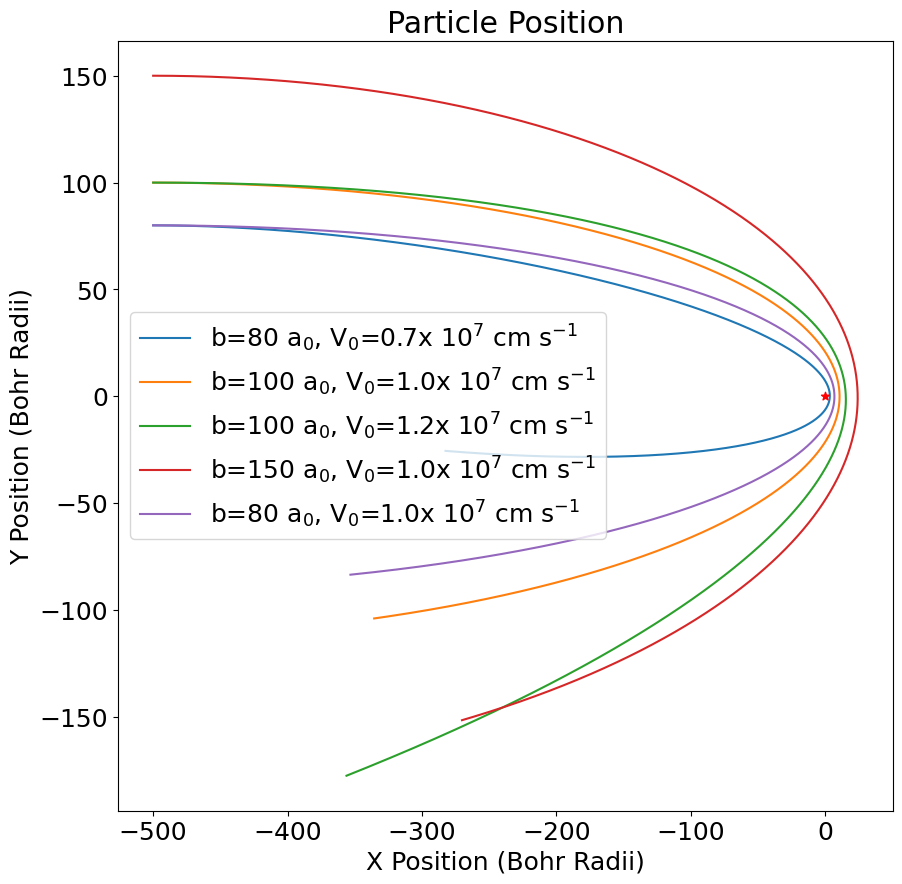

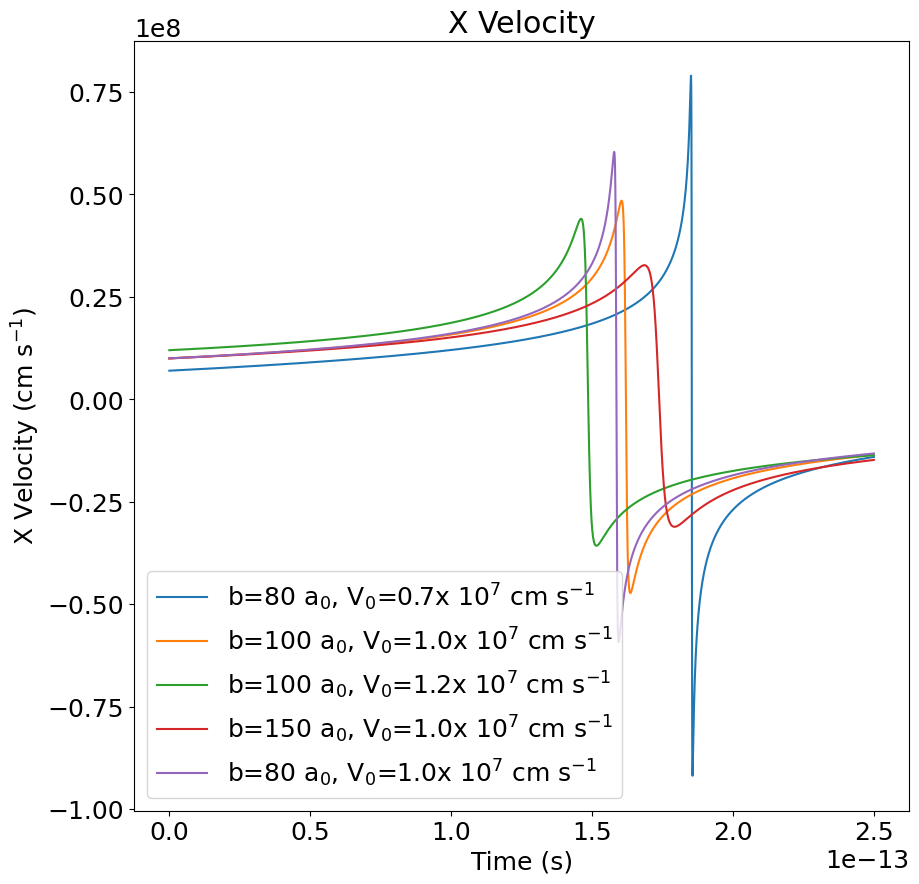

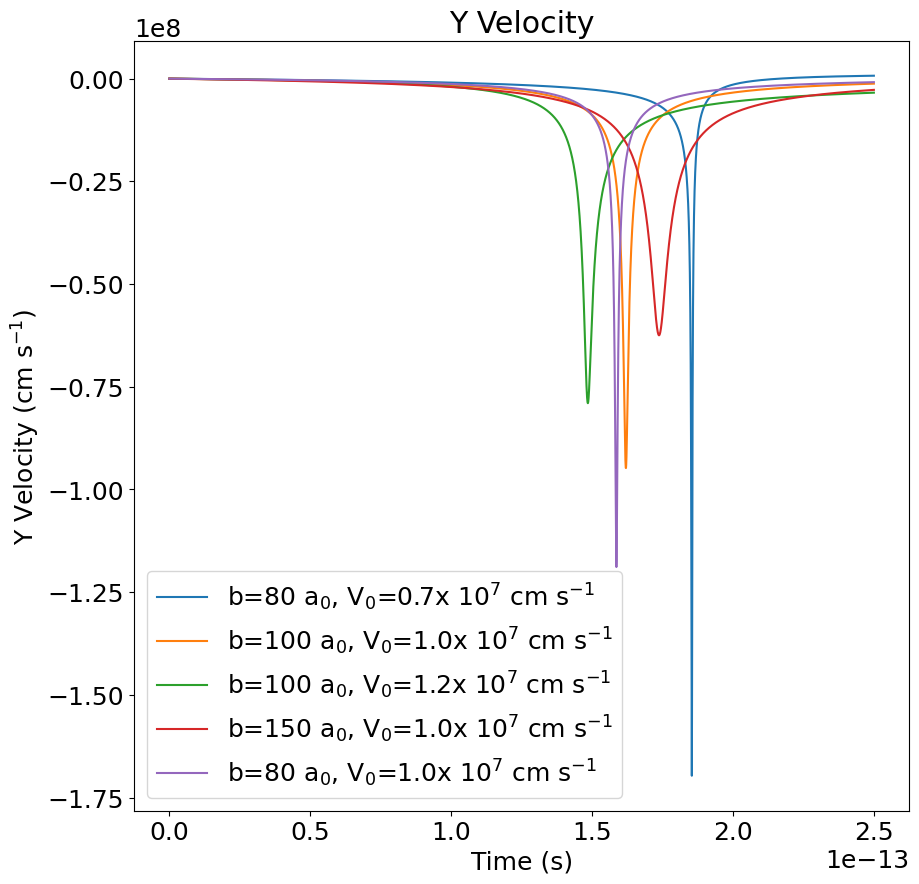

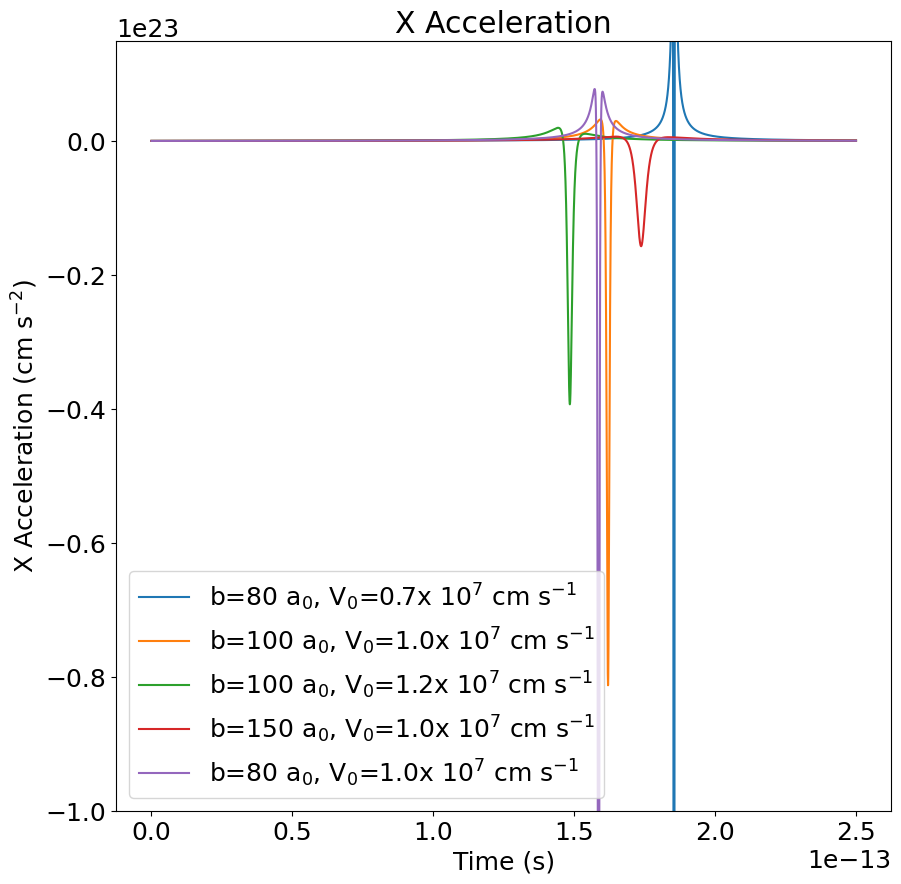

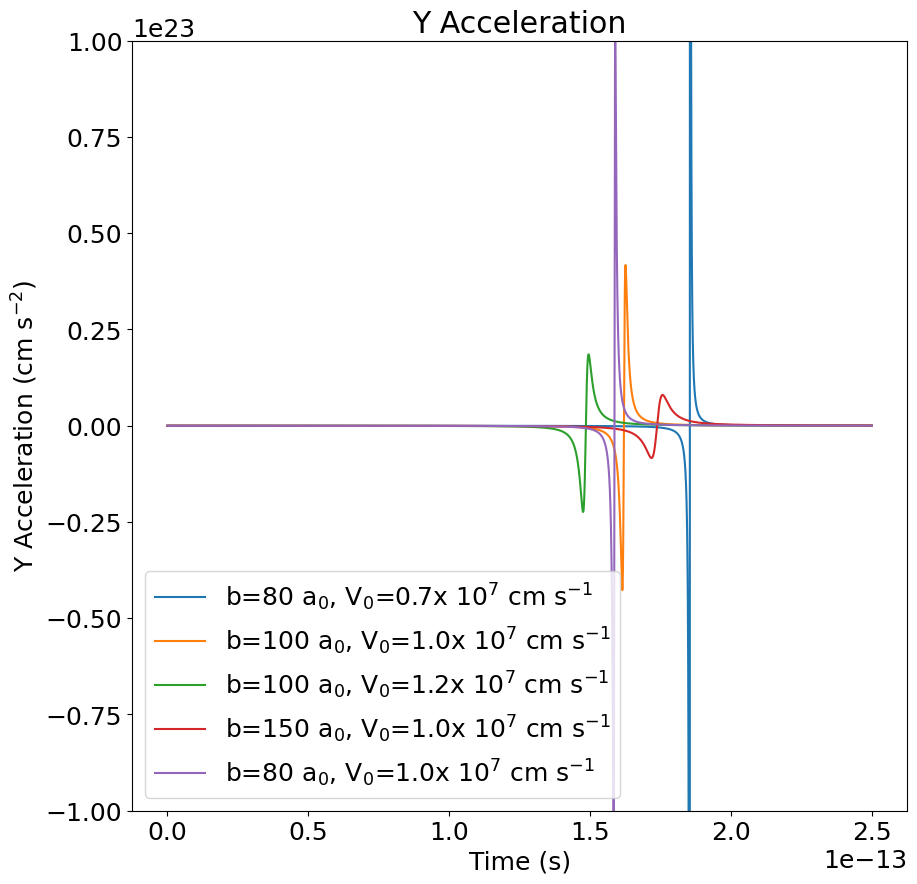

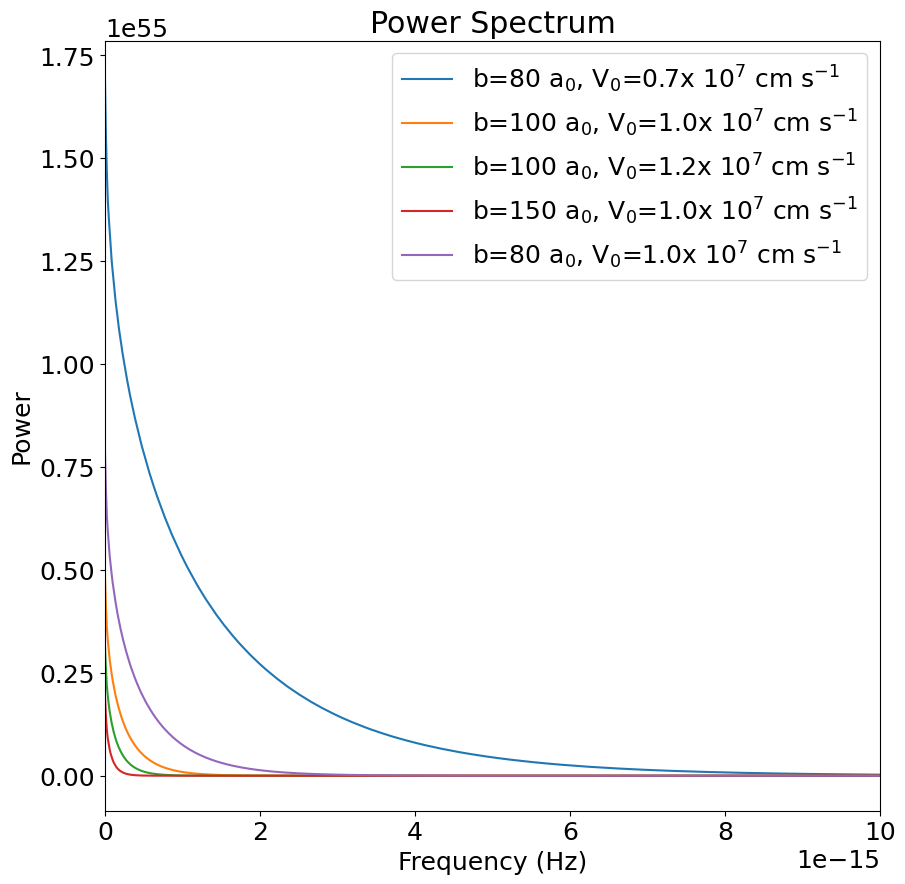

In [229]:
#characterisitc timescale of interaction, bohr radius
#divided by typical initial velocity
t_scale=1E-9/1E7

#specify initial conditions for b0, v0, and max time step for
#each simulation. Store conditions for each simulation in
#these lists
b0_list=[80,100,100,150,80]
v0_list=[.7E7,1E7,1.2E7,1E7,1E7]
t_max_list=np.array([5E3,5E3,5E3,5E3,5E3])*t_scale/2

#initial value lists for a single electron to 
#test out different values
#b0_list=[80]
#v0_list=[.7E7]
#t_max_list=np.array([20E3])*t_scale

#update fontsize, and initialize the plots
#for all 6 figures
plt.rcParams.update({'font.size': 18})
fig,ax1=plt.subplots(figsize=(10,10))
fig,ax2=plt.subplots(figsize=(10,10))
fig,ax3=plt.subplots(figsize=(10,10))
fig,ax4=plt.subplots(figsize=(10,10))
fig,ax5=plt.subplots(figsize=(10,10))
fig,ax6=plt.subplots(figsize=(10,10))

#create list holding all of the ax objects
plot_list=[ax1,ax2,ax3,ax4,ax5,ax6]

#iterate through initial conditions, and create a simulation for each case
for i in range(len(b0_list)):
    #numerical integrator
    x_list, y_list, vx_list, t_list, vy_list, ax_list, ay_list=integrate(b=b0_list[i],v0=v0_list[i],t_max=t_max_list[i],n_steps=20000)

    #plot the results for each simulation
    plots(x_list, y_list, vx_list, t_list, vy_list, ax_list, ay_list,plot_list,b0_list,v0_list,i)

#set labels for position plot and mark location of particle at the origin
ax1.set(title='Particle Position', xlabel='X Position (Bohr Radii)', ylabel='Y Position (Bohr Radii)')
ax1.scatter(0,0,marker='*',color='red',zorder=6)

#set labels of x velocity plot
ax2.set(title='X Velocity', xlabel='Time (s)', ylabel='X Velocity (cm s$^{-1}$)')

#set labels for the y velocity plot
ax3.set(title='Y Velocity', xlabel='Time (s)', ylabel='Y Velocity (cm s$^{-1}$)')

#set labels for the x acceleration plot. Adjust y axis so everything fits
ax4.set(title='X Acceleration', xlabel='Time (s)', ylabel='X Acceleration (cm s$^{-2}$)')
ax4.set_ylim(-1E23,1.5E22)

#set labels for the y acceleration plot. Adjust y axis so everything fits
ax5.set(title='Y Acceleration', xlabel='Time (s)', ylabel='Y Acceleration (cm s$^{-2}$)')
ax5.set_ylim(-1E23,1E23)

#set labels for the power spectrum plot
ax6.set(title='Power Spectrum', xlabel='Frequency (Hz)', ylabel='Power')
ax6.set_xlim(0,1E-14)

#finally, create a legend for each plot to label each simulation
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()